In [1]:
import os
import glob
import warnings
import random
import json
import math
import logging
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import zipfile
from typing import Tuple, List, Dict, Any, Optional
import copy
from pathlib import Path
from typing import List, Tuple
from collections import Counter, defaultdict

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights 

from sklearn.model_selection import StratifiedKFold, train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

warnings.filterwarnings('ignore')

C:\Users\kenne\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'mlflow'

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [3]:
class CNNLSTMConfig:
    # Data shape
    IMAGE_SIZE = (224, 224)     
    NUM_CLASSES = 2             
    SEQ_LEN = 16               # Jumlah frame per sequence

    # Model backbone
    MODEL_NAME = "efficientnet_b3"
    CNN_FEATURE_SIZE = 1536     # output EfficientNet-B7 (n_channels)
    LSTM_HIDDEN_SIZE = 256      # ukuran hidden state LSTM
    LSTM_NUM_LAYERS = 1       # 2 layers LSTM buat deeper understanding
    DROPOUT = 0.25
    ATTENTION_HEADS = 4          # jumlah attention heads untuk multi-head attention

    FEATURE_ADAPTER_DIM = 256   # dimensi adapter sebelum LSTM
    NUM_ATTENTION_HEADS = 4     # multi-head attention
    ATTENTION_DROPOUT = 0.1
    USE_RESIDUAL = True         # residual connections dalam LSTM
    USE_BIDIRECTIONAL = True    # bidirectional LSTM

    # Training params
    BATCH_SIZE = 32              # batch dalam sequence, jadi total frame = BATCH_SIZE*SEQ_LEN
    EPOCHS = 60

    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-4
    PATIENCE = 12
    MIN_DELTA = 0.001
    HEAD_LR = 3e-4
    FOCAL_ALPHA = 0.25          # focal loss alpha
    FOCAL_GAMMA = 2.0           # focal loss gamma
    LABEL_SMOOTHING = 0.05       # label smoothing factor
    COSINE_T_0 = 10              # initial restart period
    COSINE_T_MULT = 2           # restart period multiplier

    # Data augmentation
    ROTATION_RANGE = 15
    BRIGHTNESS_RANGE = 0.2
    CONTRAST_RANGE = 0.2

    LOSS = "CrossEntropy with LabelSmoothing(0.1)"


    # Directories
    DATA_DIR = "The Dataset"
    MODEL_DIR = "models/phase2_cnnlstm"
    RESULTS_DIR = "results/phase2_cnnlstm"
    LOGS_DIR = "logs"

    # MLflow
    MLFLOW_EXPERIMENT_NAME = "car_exit_detection_cnnlstm"
    MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

    def __init__(self):
        self.create_directories()
        self.setup_mlflow()

    def create_directories(self):
        directories = [self.MODEL_DIR, self.RESULTS_DIR, self.LOGS_DIR, "mlruns"]
        for dir_path in directories:
            os.makedirs(dir_path, exist_ok=True)
            logger.info(f"Created directory: {dir_path}")

    def setup_mlflow(self):
        mlflow.set_tracking_uri(self.MLFLOW_TRACKING_URI)
        try:
            mlflow.set_experiment(self.MLFLOW_EXPERIMENT_NAME)
            experiment = mlflow.get_experiment_by_name(self.MLFLOW_EXPERIMENT_NAME)
            if experiment is None:
                mlflow.create_experiment(self.MLFLOW_EXPERIMENT_NAME)
                logger.info(f"Created MLFlow experiment: {self.MLFLOW_EXPERIMENT_NAME}")
            else:
                logger.info(f"Using existing MLFlow experiment: {self.MLFLOW_EXPERIMENT_NAME}")
        except Exception as e:
            logger.error(f"MLFlow setup failed: {e}")
            raise


In [4]:
class FocalLoss(nn.Module):

    """Focal Loss buat handle class imbalance"""
    
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [5]:
class LabelSmoothingCrossEntropy(nn.Module):

    """Label Smoothing Cross Entropy untuk regularization"""
    
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        log_prob = F.log_softmax(inputs, dim=-1)
        targets = torch.zeros_like(log_prob).scatter_(1, targets.unsqueeze(1), 1)
        targets = (1 - self.smoothing) * targets + self.smoothing / inputs.size(-1)
        return (-targets * log_prob).sum(dim=-1).mean()

In [6]:
class CombinedLoss(nn.Module):

    """Kombinasi Focal Loss dan Label Smoothing"""
    
    def __init__(self, focal_alpha=0.25, focal_gamma=2.0, smoothing=0.1, focal_weight=0.7):
        super().__init__()
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        self.smooth_loss = LabelSmoothingCrossEntropy(smoothing=smoothing)
        self.focal_weight = focal_weight

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        smooth = self.smooth_loss(inputs, targets)
        return self.focal_weight * focal + (1 - self.focal_weight) * smooth

In [7]:
class CarExitSequenceDataset(Dataset):
    
    def __init__(self, sequences, transform, target_len=16):
        self.sequences = sequences
        self.transform = transform
        self.target_len = target_len

    def __len__(self): return len(self.sequences)

    def __getitem__(self, idx):
        item = self.sequences[idx]
        frames, label = item["frame_paths"], item["label"]
        if len(frames) >= self.target_len:
            sel_idx = np.linspace(0, len(frames)-1, self.target_len).astype(int)
            chosen = [frames[i] for i in sel_idx]
            length = self.target_len
        else:
            chosen = frames + [frames[-1]] * (self.target_len - len(frames))
            length = len(frames)
        imgs = [self.transform(Image.open(fp).convert('RGB')) for fp in chosen]
        x = torch.stack(imgs, dim=0)
        return x, torch.tensor(label, dtype=torch.long), torch.tensor(length, dtype=torch.long)

def seq_collate(batch):
    xs, ys, ls = zip(*batch)
    return torch.stack(xs, 0), torch.stack(ys, 0), torch.stack(ls, 0)

In [8]:
class CNNFeatureExtractor(nn.Module):

    """
    Ekstraktor fitur frame berbasis EfficientNet-B7 (tanpa classifier).
    - Jika input (B, C, H, W) -> output (B, D)
    - Jika input (B, T, C, H, W) -> output (B, T, D)
    D = cnn_feature_size (Eff-B7 = 2560).
    """
    
    def __init__(self, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.backbone.classifier = nn.Identity()  # keluarkan vektor fitur akhir (B, 1536)

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:  # (B, C, H, W)
            return self.backbone(x)  # (B, D)

        elif x.dim() == 5:  # (B, T, C, H, W)
            B, T, C, H, W = x.shape
            x_flat = x.view(B * T, C, H, W)
            feats = self.backbone(x_flat)         # (B*T, D)
            D = feats.shape[1]
            return feats.view(B, T, D)            # (B, T, D)

        else:
            raise ValueError(f"Unexpected input shape: {x.shape}")

In [9]:
class MultiHeadAttention(nn.Module):

    """ Multi-Head Attention buat temporal modeling """
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        # x: (B, T, d_model)
        batch_size, seq_len = x.size(0), x.size(1)
        residual = x
        
        # Linear transformations
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Attention
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )
        
        # Outputnya projection dan residual
        output = self.w_o(attention_output)
        output = self.dropout(output)
        return self.layer_norm(output + residual)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        return torch.matmul(attention_weights, V)

In [10]:
class FeatureAdapter(nn.Module):

    """ Adapter layer buat mapping CNN features ke sequence modeling """

    def __init__(self, input_dim, output_dim, dropout=0.1):
        super().__init__()
        self.adapter = nn.Sequential(
            nn.Linear(input_dim, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(output_dim * 2, output_dim),
            nn.LayerNorm(output_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.residual = nn.Linear(input_dim, output_dim) if input_dim != output_dim else nn.Identity()
        
    def forward(self, x):
        # x: (B, T, input_dim) atau (B*T, input_dim)
        original_shape = x.shape
        if len(original_shape) == 3:
            B, T, D = original_shape
            x = x.view(B*T, D)
            adapted = self.adapter(x) + self.residual(x)
            return adapted.view(B, T, -1)
        else:
            return self.adapter(x) + self.residual(x)

In [11]:
class SequenceHeadLSTM(nn.Module):

    """
    Enhanced Head temporal LSTM dengan Multi-Head Attention, Bidirectional LSTM, dan Residual connections.
    Input :
      feats   : (B, T, D)  -> fitur dari CNN per frame
      lengths : (B,)       -> panjang asli tiap sequence (<= T)
    Output:
      logits  : (B, num_classes)
    """

    def __init__(self, feat_dim: int = 1536, adapter_dim: int = 512, hidden: int = 512, 
                 layers: int = 1, num_classes: int = 2, bidirectional: bool = True, 
                 dropout: float = 0.3, num_attention_heads: int = 8, use_residual: bool = True):
        super().__init__()
        
        # Feature adapter
        self.feature_adapter = FeatureAdapter(feat_dim, adapter_dim, dropout)
        
        # Multi-head attention
        self.attention = MultiHeadAttention(
            d_model=adapter_dim, 
            num_heads=num_attention_heads, 
            dropout=dropout
        )
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=adapter_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=(dropout if layers > 1 else 0.0),
        )
        
        # Residual connection params
        self.use_residual = use_residual
        if use_residual:
            lstm_out_dim = hidden * (2 if bidirectional else 1)
            self.residual_proj = nn.Linear(adapter_dim, lstm_out_dim)
        
        out_dim = hidden * (2 if bidirectional else 1)
        
        # Enhanced classifier dengan lebih banyak layer
        self.classifier = nn.Sequential(
            nn.Linear(out_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

        self._init_classifier()

    def _init_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def create_attention_mask(self, lengths, max_len):

        """ attention mask untuk variable length sequences """

        batch_size = len(lengths)
        mask = torch.zeros(batch_size, max_len, dtype=torch.bool, device=lengths.device)
        for i, length in enumerate(lengths):
            mask[i, :length] = True
        return mask.unsqueeze(1).unsqueeze(1)  # (B, 1, 1, T) untuk broadcasting

    def forward(self, feats: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        # feats: (B, T, D), lengths harus di CPU untuk pack
        B, T, D = feats.shape
        
        # Feature adaptation
        adapted_feats = self.feature_adapter(feats)  # (B, T, adapter_dim)
        
        # Multi-head attention dengan mask
        attention_mask = self.create_attention_mask(lengths, T)
        attended_feats = self.attention(adapted_feats, mask=attention_mask)  # (B, T, adapter_dim)
        
        # LSTM processing
        packed = nn.utils.rnn.pack_padded_sequence(
            attended_feats, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        lstm_out, (h_n, _) = self.lstm(packed)  # h_n: (num_layers * num_dirs, B, H)
        
        # Unpack untuk residual connection
        if self.use_residual:
            unpacked_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
            seq_mask = torch.arange(T, device=feats.device).unsqueeze(0) < lengths.unsqueeze(1)
            seq_mask = seq_mask.unsqueeze(-1).float()  # (B, T, 1)
            
            pooled_attended = (attended_feats * seq_mask).sum(dim=1) / lengths.unsqueeze(1).float()
            pooled_attended = self.residual_proj(pooled_attended)  # (B, lstm_out_dim)

        # final hidden state
        if self.lstm.bidirectional:
            h_last = torch.cat([h_n[-2], h_n[-1]], dim=1)  # (B, 2H)
        else:
            h_last = h_n[-1]                               # (B, H)

        # Add residual connection
        if self.use_residual:
            h_last = h_last + pooled_attended

        logits = self.classifier(h_last)                   # (B, num_classes)
        return logits

In [12]:
class CNNLSTMModel(nn.Module):

    """
    Enhanced CNN+LSTM model dengan Multi-Head Attention dan Feature Adapter.
    Input : x (B,T,C,H,W), lengths (B,)
    Output: logits (B,num_classes)
    """

    def __init__(self, num_classes=2, cnn_feature_size=1536, adapter_dim=512,
                 lstm_hidden=512, lstm_layers=1, bidirectional=True, dropout=0.3,
                 num_attention_heads=8, use_residual=True, freeze_backbone=True):
        super().__init__()
        self.extractor = CNNFeatureExtractor(freeze_backbone=freeze_backbone)
        self.head = SequenceHeadLSTM(
            feat_dim=cnn_feature_size,
            adapter_dim=adapter_dim,
            hidden=lstm_hidden,
            layers=lstm_layers,
            num_classes=num_classes,
            bidirectional=bidirectional,
            dropout=dropout,
            num_attention_heads=num_attention_heads,
            use_residual=use_residual
        )

    def forward(self, x_btchw: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        feats = self.extractor(x_btchw)            # (B, T, D)
        logits = self.head(feats, lengths)         # (B, num_classes)
        return logits
    
def create_weighted_sampler(sequences, config):

    """ Bikin WeightedRandomSampler untuk mengatasi class imbalance """

    labels = [s["label"] for s in sequences]
    class_counts = Counter(labels)
    
    # Hitung weight per class 
    total_samples = len(sequences)
    class_weights = {}
    for cls, count in class_counts.items():
        class_weights[cls] = total_samples / (len(class_counts) * count)
    
    # Assign weight ke setiap sample
    sample_weights = [class_weights[label] for label in labels]
    
    logger.info(f"Class weights: {class_weights}")
    logger.info(f"Sample weights range: {min(sample_weights):.3f} - {max(sample_weights):.3f}")
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

In [13]:
class CNNLSTMTrainer:
    def __init__(self, config, device: torch.device):
        self.config = config
        self.device = device
        self.config.HEAD_LR = getattr(self.config, "HEAD_LR", 1e-3)
        self.config.SEQ_LEN = getattr(self.config, "SEQ_LEN", 16)

    def create_transforms(self) -> Tuple[transforms.Compose, transforms.Compose]:
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(self.config.IMAGE_SIZE, scale=(0.85, 1.0)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomRotation(degrees=self.config.ROTATION_RANGE),
            transforms.ColorJitter(
                brightness=self.config.BRIGHTNESS_RANGE,
                contrast=self.config.CONTRAST_RANGE,
                saturation=0.1,
                hue=0.05
            ),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
        ])

        val_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(self.config.IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])
        return train_transform, val_transform

    def _build_head_optimizer(self, model: nn.Module) -> AdamW:
        head_params = list(model.head.parameters())
        optimizer = AdamW(head_params, lr=self.config.HEAD_LR, weight_decay=self.config.WEIGHT_DECAY)
        return optimizer

    def train_val_once(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        run_name: str = None
    ) -> Tuple[nn.Module, Dict, float]:
        
        is_active = mlflow.active_run() is not None

        with mlflow.start_run(run_name=run_name, nested=is_active):
            mlflow.log_params({
                'phase': 'Enhanced Stage-1 (freeze CNN, train enhanced LSTM+Attention+FC)',
                'image_size': str(self.config.IMAGE_SIZE),
                'seq_len': self.config.SEQ_LEN,
                'batch_size': self.config.BATCH_SIZE,
                'epochs': self.config.EPOCHS,
                'head_lr': self.config.HEAD_LR,
                'weight_decay': self.config.WEIGHT_DECAY,
                'dropout': self.config.DROPOUT,
                'lstm_hidden': getattr(self.config, "LSTM_HIDDEN_SIZE", 512),
                'lstm_layers': getattr(self.config, "LSTM_NUM_LAYERS", 1),
                'backbone': getattr(self.config, "MODEL_NAME", "efficientnet_b3"),
                'freeze_backbone': True,
                'feature_adapter_dim': getattr(self.config, "FEATURE_ADAPTER_DIM", 512),
                'num_attention_heads': getattr(self.config, "NUM_ATTENTION_HEADS", 8),
                'use_bidirectional': getattr(self.config, "USE_BIDIRECTIONAL", True),
                'use_residual': getattr(self.config, "USE_RESIDUAL", True),
                'focal_alpha': getattr(self.config, "FOCAL_ALPHA", 0.25),
                'focal_gamma': getattr(self.config, "FOCAL_GAMMA", 2.0),
                'label_smoothing': getattr(self.config, "LABEL_SMOOTHING", 0.1),
            })

            # Enhanced Combined Loss
            criterion = CombinedLoss(
                focal_alpha=self.config.FOCAL_ALPHA,
                focal_gamma=self.config.FOCAL_GAMMA,
                smoothing=self.config.LABEL_SMOOTHING,
                focal_weight=0.7
            )
            
            optimizer = self._build_head_optimizer(model)
            
            # Cosine Annealing with Warm Restarts
            scheduler = CosineAnnealingWarmRestarts(
                optimizer,
                T_0=self.config.COSINE_T_0,
                T_mult=self.config.COSINE_T_MULT,
                eta_min=self.config.HEAD_LR * 0.01
            )

            history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
            best_val_acc, best_state, patience_counter = 0.0, None, 0

            for epoch in range(self.config.EPOCHS):
                model.train()
                train_loss_sum, train_correct, train_total = 0.0, 0, 0
                pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.config.EPOCHS}', leave=False)

                for images, labels, lengths in pbar:
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    lengths = lengths.to(self.device)

                    optimizer.zero_grad()
                    outputs = model(images, lengths)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    scheduler.step()  # Step setelah setiap batch untuk warm restarts

                    bs = labels.size(0)
                    train_loss_sum += loss.item() * bs
                    _, pred = outputs.max(1)
                    train_total += bs
                    train_correct += (pred == labels).sum().item()

                    pbar.set_postfix(loss=f'{loss.item():.4f}',
                                     acc=f'{100.0*train_correct/max(train_total,1):.1f}%')

                epoch_train_loss = train_loss_sum / max(train_total, 1)
                epoch_train_acc  = train_correct / max(train_total, 1)

                model.eval()
                val_loss_sum, val_correct, val_total = 0.0, 0, 0
                with torch.no_grad():
                    for images, labels, lengths in val_loader:
                        images = images.to(self.device)
                        labels = labels.to(self.device)
                        lengths = lengths.to(self.device)

                        outputs = model(images, lengths)
                        loss = criterion(outputs, labels)

                        bs = labels.size(0)
                        val_loss_sum += loss.item() * bs
                        _, pred = outputs.max(1)
                        val_total += bs
                        val_correct += (pred == labels).sum().item()

                epoch_val_loss = val_loss_sum / max(val_total, 1)
                epoch_val_acc  = val_correct / max(val_total, 1)

                history['train_loss'].append(epoch_train_loss)
                history['train_acc'].append(epoch_train_acc)
                history['val_loss'].append(epoch_val_loss)
                history['val_acc'].append(epoch_val_acc)

                mlflow.log_metrics({
                    'train_loss': epoch_train_loss,
                    'train_acc': epoch_train_acc,
                    'val_loss': epoch_val_loss,
                    'val_acc': epoch_val_acc,
                    'learning_rate': scheduler.get_last_lr()[0]
                }, step=epoch)

                logger.info(
                    f"Epoch {epoch+1}/{self.config.EPOCHS} "
                    f"Train: {epoch_train_loss:.4f}/{epoch_train_acc:.4f} "
                    f"Val: {epoch_val_loss:.4f}/{epoch_val_acc:.4f} "
                    f"LR: {scheduler.get_last_lr()[0]:.6f}"
                )

                if epoch_val_acc > best_val_acc + self.config.MIN_DELTA:
                    best_val_acc = epoch_val_acc
                    best_state = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    logger.info(f"New best model — Val Acc: {epoch_val_acc:.4f}")
                else:
                    patience_counter += 1
                    if patience_counter >= self.config.PATIENCE:
                        logger.info(f"Early stopping at epoch {epoch+1}")
                        break

            if best_state is not None:
                model.load_state_dict(best_state)

            os.makedirs(self.config.MODEL_DIR, exist_ok=True)
            best_model_path = os.path.join(self.config.MODEL_DIR, 'best_cnnlstm_stage1.pth')
            torch.save({'model_state_dict': model.state_dict(),
                        'best_val_acc': best_val_acc,
                        'config': self.config.__dict__}, best_model_path)
            mlflow.log_artifact(best_model_path, "models")

            return model, history, best_val_acc


In [14]:
def load_sequence_index(data_dir: str) -> List[Dict]:

    """
    Return list of sequence dict:
      [
        {"sequence_id": "0_seq001", "frame_paths": [...], "label": 0},
        {"sequence_id": "1_seq123", "frame_paths": [...], "label": 1},
        ...
      ]
    Struktur diasumsikan: data_dir/{0,1}/{seq_name}/*.jpg|png|jpeg|bmp
    """

    root = Path(data_dir)
    exts = {'.jpg', '.jpeg', '.png', '.bmp'}
    sequences: List[Dict] = []

    for cls in [0, 1]:
        class_dir = root / str(cls)
        if not class_dir.exists():
            logger.warning(f"Class directory {class_dir} not found")
            continue

        for seq_dir in sorted([p for p in class_dir.iterdir() if p.is_dir()]):
            frames = sorted([f for f in seq_dir.iterdir()
                             if f.is_file() and f.suffix.lower() in exts])
            if not frames:
                logger.warning(f"No images in sequence {seq_dir}")
                continue

            sequences.append({
                "sequence_id": f"{cls}_{seq_dir.name}",
                "frame_paths": [str(x) for x in frames],
                "label": int(cls),
            })

    if not sequences:
        raise ValueError("No sequences found.")

    logger.info(f"Loaded {len(sequences)} sequences "
                f"({sum(len(s['frame_paths']) for s in sequences)} frames total)")
    return sequences

def split_train_val_sequences(sequences, val_size=0.2, seed=42):

    """
    Split sekali anti-leak: semua frame dari 1 sequence jatuh ke train ATAU val saja.
    """
    
    groups = [s["sequence_id"] for s in sequences]
    labels = [s["label"] for s in sequences]

    gss = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
    train_idx, val_idx = next(gss.split(sequences, labels, groups))

    train_seq = [sequences[i] for i in train_idx]
    val_seq   = [sequences[i] for i in val_idx]

    logger.info(f"Train sequences: {len(train_seq)} | Val sequences: {len(val_seq)}")
    return train_seq, val_seq


In [15]:
def visualize_trainval_history(history: Dict, config, title: str = "Enhanced CNN+LSTM Stage-1",
                               best_val_acc: float = None, filename: str = "trainval_history_stage1.png"):
    
    """
    history: dict dengan keys:
        - 'train_acc', 'val_acc', 'train_loss', 'val_loss'  (list per-epoch)
    config : punya RESULTS_DIR untuk lokasi simpan
    """
    
    train_acc = np.array(history.get('train_acc', []), dtype=float)
    val_acc   = np.array(history.get('val_acc', []), dtype=float)
    train_ls  = np.array(history.get('train_loss', []), dtype=float)
    val_ls    = np.array(history.get('val_loss', []), dtype=float)

    epochs = np.arange(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))

    # Acc panel
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(epochs, train_acc, label='Train Acc', linewidth=2)
    ax1.plot(epochs, val_acc,   label='Val Acc',   linewidth=2)
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy per Epoch')
    ax1.grid(True, alpha=0.3); ax1.legend()

    # Loss panel
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, train_ls, label='Train Loss', linewidth=2)
    ax2.plot(epochs, val_ls,   label='Val Loss',   linewidth=2)
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
    ax2.set_title('Loss per Epoch')
    ax2.grid(True, alpha=0.3); ax2.legend()

    suptitle = title if best_val_acc is None else f"{title}  |  Best Val Acc: {best_val_acc:.4f}"
    plt.suptitle(suptitle, fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(config.RESULTS_DIR, exist_ok=True)
    out_path = os.path.join(config.RESULTS_DIR, filename)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()

    mlflow.log_artifact(out_path)
    return out_path

In [16]:
def evaluate_test_set_sequence(
    model: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    config
) -> dict:
    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels, lengths in tqdm(test_loader, desc="Evaluating test set"):
            images  = images.to(device)    # (B,T,C,H,W)
            labels  = labels.to(device)    # (B,)
            lengths = lengths.to(device)   # (B,)

            outputs = model(images, lengths)          # (B,num_classes)
            _, pred = torch.max(outputs.data, dim=1)  # (B,)

            test_total   += labels.size(0)
            test_correct += (pred == labels).sum().item()

            all_preds.extend(pred.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Metrics (dengan zero_division=0 agar aman kalau ada kelas kosong)
    accuracy   = test_correct / max(test_total, 1)
    f1_w       = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    prec_w     = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec_w      = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    f1_per     = f1_score(all_labels, all_preds, average=None, zero_division=0)
    prec_per   = precision_score(all_labels, all_preds, average=None, zero_division=0)
    rec_per    = recall_score(all_labels, all_preds, average=None, zero_division=0)

    metrics = {
        'accuracy': accuracy,
        'f1_weighted': f1_w,
        'precision_weighted': prec_w,
        'recall_weighted': rec_w,
        'f1_normal': f1_per[0] if len(f1_per) > 0 else 0.0,
        'f1_person_exiting': f1_per[1] if len(f1_per) > 1 else 0.0,
        'precision_normal': prec_per[0] if len(prec_per) > 0 else 0.0,
        'precision_person_exiting': prec_per[1] if len(prec_per) > 1 else 0.0,
        'recall_normal': rec_per[0] if len(rec_per) > 0 else 0.0,
        'recall_person_exiting': rec_per[1] if len(rec_per) > 1 else 0.0,
        'test_samples': test_total
    }

    # Confusion Matrix
    class_names = ['Normal Parking', 'Person Exiting']
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Test Set Confusion Matrix', fontweight='bold', fontsize=14)
    plt.ylabel('True Label'); plt.xlabel('Predicted Label')

    os.makedirs(config.RESULTS_DIR, exist_ok=True)
    cm_path = os.path.join(config.RESULTS_DIR, 'test_confusion_matrix_seq.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight'); plt.show()
    mlflow.log_artifact(cm_path)

    # Classification report (log ke logger)
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    logger.info("\nTEST SET EVALUATION (SEQUENCE):")
    logger.info(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    logger.info(f"F1 (weighted): {f1_w:.4f} | Precision (weighted): {prec_w:.4f} | Recall (weighted): {rec_w:.4f}")
    logger.info(f"\nDetailed Classification Report:\n{report}")

    return metrics

In [17]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def main():
    try:
        # ---------- setup ----------
        set_seed(42)
        config = CNNLSTMConfig()  # ganti ke config sequence kamu (bukan CNNConfig lama)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(device)
        logger.info(f"Device: {device}")
        if torch.cuda.is_available():
            mem_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
            logger.info(f"GPU Memory: {mem_gb:.1f} GB")

        # ---------- load sequences ----------
        sequences = load_sequence_index(config.DATA_DIR)  # -> list of dicts (sequence-level)
        class_counts = {
            0: sum(1 for s in sequences if s["label"] == 0),
            1: sum(1 for s in sequences if s["label"] == 1),
        }
        logger.info(f"Sequence count: {len(sequences)} | Class dist (seq): {class_counts}")

        # sekali split train/val tanpa test (anti-leak per sequence)
        train_seq, val_seq = split_train_val_sequences(sequences, val_size=0.2, seed=42)
        logger.info(f"Train sequences: {len(train_seq)} | Val sequences: {len(val_seq)}")

        # ---------- transforms ----------
        trainer = CNNLSTMTrainer(config, device)
        train_tf, val_tf = trainer.create_transforms()

        # ---------- datasets & loaders ----------
        train_ds = CarExitSequenceDataset(train_seq, transform=train_tf, target_len=config.SEQ_LEN)
        val_ds   = CarExitSequenceDataset(val_seq,   transform=val_tf,   target_len=config.SEQ_LEN)

        # Create weighted sampler untuk train set
        weighted_sampler = create_weighted_sampler(train_seq, config)

        train_loader = DataLoader(
            train_ds,
            batch_size=config.BATCH_SIZE,
            sampler=weighted_sampler,  # gunakan weighted sampler dibandingkan shuffle
            num_workers=0,
            pin_memory=(device.type == 'cuda'),
            collate_fn=seq_collate
        )
        val_loader = DataLoader(
            val_ds,
            batch_size=config.BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            pin_memory=(device.type == 'cuda'),
            collate_fn=seq_collate
        )

        model = CNNLSTMModel(
            num_classes=config.NUM_CLASSES,
            cnn_feature_size=config.CNN_FEATURE_SIZE,   # 2560 for EffNet-B7
            adapter_dim=config.FEATURE_ADAPTER_DIM,     # feature adapter dimension
            lstm_hidden=config.LSTM_HIDDEN_SIZE,
            lstm_layers=config.LSTM_NUM_LAYERS,
            bidirectional=config.USE_BIDIRECTIONAL,    # bidirectional LSTM
            dropout=config.DROPOUT,
            num_attention_heads=config.NUM_ATTENTION_HEADS,  # multi-head attention
            use_residual=config.USE_RESIDUAL,          # residual connections
            freeze_backbone=True,                       # penting: bekukan CNN
        ).to(device)

        # jumlah param trainable vs frozen
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen    = sum(p.numel() for p in model.parameters() if not p.requires_grad)
        logger.info(f"Trainable params: {trainable:,} | Frozen params: {frozen:,}")

        # ---------- train once (no K-Fold) ----------
        run_name = f"enhanced_cnn_lstm_stage1_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        best_model, history, best_val_acc = trainer.train_val_once(model, train_loader, val_loader, run_name=run_name)

        # ---------- visualize ----------
        plot_path = visualize_trainval_history(
            history, config,
            title="Enhanced CNN+LSTM Stage-1 (Freeze CNN + Attention + Residual)",
            best_val_acc=best_val_acc,
            filename="trainval_history_enhanced_stage1.png"
        )
        logger.info(f"Saved plot: {plot_path}")

        # ---------- save summary ----------
        results_summary = {
            'timestamp': datetime.now().isoformat(),
            'phase': 'Enhanced Stage 1 - CNN+LSTM (freeze CNN, train enhanced LSTM+Attention+FC)',
            'model_architecture': 'EfficientNet-B7 (frozen) + Feature Adapter + Multi-Head Attention + Bidirectional LSTM + Residual + Enhanced FC',
            'config': {
                'model_name': config.MODEL_NAME,
                'image_size': config.IMAGE_SIZE,
                'seq_len': config.SEQ_LEN,
                'batch_size': config.BATCH_SIZE,
                'epochs': config.EPOCHS,
                'head_lr': getattr(config, "HEAD_LR", 1e-3),
                'weight_decay': config.WEIGHT_DECAY,
                'dropout': config.DROPOUT,
                'lstm_hidden': config.LSTM_HIDDEN_SIZE,
                'lstm_layers': config.LSTM_NUM_LAYERS,
                'freeze_backbone': True,
                'feature_adapter_dim': config.FEATURE_ADAPTER_DIM,
                'num_attention_heads': config.NUM_ATTENTION_HEADS,
                'use_bidirectional': config.USE_BIDIRECTIONAL,
                'use_residual': config.USE_RESIDUAL,
                'focal_alpha': config.FOCAL_ALPHA,
                'focal_gamma': config.FOCAL_GAMMA,
                'label_smoothing': config.LABEL_SMOOTHING,
                'cosine_t_0': config.COSINE_T_0,
                'cosine_t_mult': config.COSINE_T_MULT
            },
            'data_info': {
                'total_sequences': len(sequences),
                'train_sequences': len(train_seq),
                'val_sequences': len(val_seq),
                'class_distribution_sequences': class_counts
            },
            'final_val': {
                'best_val_acc': best_val_acc,
                'epochs_ran': len(history.get('val_acc', []))
            }
        }

        os.makedirs(config.RESULTS_DIR, exist_ok=True)
        results_path = os.path.join(config.RESULTS_DIR, 'enhanced_stage1_cnnlstm_results.json')
        with open(results_path, 'w') as f:
            json.dump(results_summary, f, indent=2)
        mlflow.log_artifact(results_path)

        logger.info(f"Best Val Accuracy: {best_val_acc:.4f}")
        logger.info("\nSAVED FILES:")
        logger.info(f"   Best model: {config.MODEL_DIR}/best_cnnlstm_stage1.pth")
        logger.info(f"   Results summary: {results_path}")
        logger.info(f"   Visualizations: {config.RESULTS_DIR}/")
        logger.info(f"   MLFlow tracking: {config.MLFLOW_TRACKING_URI}")

        return best_model, history, results_summary

    except Exception as e:
        logger.error(f"Training pipeline failed: {e}")
        import traceback; traceback.print_exc()
        return None, None, None

In [18]:
def inspect_dataset_root(data_dir: str, max_corrupt_check_per_seq: int = 3):

    """
    Struktur asumsi:
      data_dir/
        0/
          seq_001/ frame_0001.jpg ...
          seq_002/ ...
        1/
          seq_101/ ...
    Output:
      - sequences: list[dict] = [{"sequence_id", "label", "frame_paths"}]
      - prints: ringkasan super detail soal isi dataset SEBELUM proses apa pun
    """
    
    root = Path(data_dir)
    if not root.exists():
        raise FileNotFoundError(f"DATA_DIR nggak ada: {root}")

    sequences = []
    empty_sequences = []
    non_image_files = []
    exts_ok = {".jpg", ".jpeg", ".png", ".bmp"}

    # 1) Scan folder per label
    for label in [0, 1]:
        class_dir = root / str(label)
        if not class_dir.exists():
            print(f"[WARN] Folder kelas tidak ditemukan: {class_dir}")
            continue
        seq_dirs = sorted([p for p in class_dir.iterdir() if p.is_dir()])

        for sd in seq_dirs:
            # kumpulkan file gambar valid (by extension)
            all_files = sorted([p for p in sd.iterdir() if p.is_file()])
            imgs = [p for p in all_files if p.suffix.lower() in exts_ok]
            others = [p for p in all_files if p.suffix.lower() not in exts_ok]
            non_image_files.extend(others)

            if len(imgs) == 0:
                empty_sequences.append(sd)
                continue

            sequences.append({
                "sequence_id": f"{label}_{sd.name}",
                "label": label,
                "frame_paths": [str(p) for p in imgs],  # simpan string path
            })

    # 2) Ringkasan dasar
    n_seq = len(sequences)
    by_label = Counter([s["label"] for s in sequences])

    print("\n================ RAW DATA SUMMARY ================")
    print(f"Root           : {root.resolve()}")
    print(f"Total sequences: {n_seq}")
    for k in sorted(by_label.keys()):
        print(f"  Label {k}      : {by_label[k]} sequences")

    if empty_sequences:
        print(f"\n[WARN] Empty sequences (tanpa frame): {len(empty_sequences)}")
        for p in empty_sequences[:10]:
            print(f"   - {p}")
        if len(empty_sequences) > 10:
            print(f"   ... ({len(empty_sequences)-10} lagi)")

    if non_image_files:
        print(f"\n[INFO] Non-image files terdeteksi: {len(non_image_files)}")
        for p in non_image_files[:10]:
            print(f"   - {p.name}")
        if len(non_image_files) > 10:
            print(f"   ... ({len(non_image_files)-10} lagi)")

    # 3) Statistik panjang sequence (jumlah frame)
    lens = np.array([len(s["frame_paths"]) for s in sequences], dtype=int)
    if len(lens) > 0:
        q = np.quantile(lens, [0, 0.25, 0.5, 0.75, 1.0])
        print("\nSequence length stats (jumlah frame per sequence):")
        print(f"  Min/25%/Med/75%/Max : {int(q[0])} / {int(q[1])} / {int(q[2])} / {int(q[3])} / {int(q[4])}")
        print(f"  Mean ± Std          : {lens.mean():.2f} ± {lens.std():.2f}")


        # histogram sederhana
        hist = defaultdict(int)
        for L in lens:
            # bucketin per 5 frame biar kebaca
            bucket = int(L // 5) * 5
            hist[bucket] += 1
        top = sorted(hist.items())[:10]
        print("  Contoh histogram (bucket 5‑frame):")
        for b, c in top:
            print(f"    {b:>3d}–{b+4:>3d} : {c}")
        # 3b) Deteksi sequence dengan frame <15 atau >15
    too_short = [s for s in sequences if len(s["frame_paths"]) < 16]
    too_long  = [s for s in sequences if len(s["frame_paths"]) > 16]

    if too_short:
        print(f"\n[INFO] Sequence dengan <16 frame: {len(too_short)}")
        for s in too_short[:10]:
            print(f"   - {s['sequence_id']} ({len(s['frame_paths'])} frame)")
        if len(too_short) > 10:
            print(f"   ... ({len(too_short)-10} lagi)")

    if too_long:
        print(f"\n[INFO] Sequence dengan >16 frame: {len(too_long)}")
        for s in too_long[:10]:
            print(f"   - {s['sequence_id']} ({len(s['frame_paths'])} frame)")
        if len(too_long) > 10:
            print(f"   ... ({len(too_long)-10} lagi)")

    # 4) Cek cepat korup/ga kebaca (sample beberapa frame per sequence)
    #    Tujuan: sebelum training, kita tahu ada file rusak atau tidak.
    bad_images = []
    for s in sequences[: min(len(sequences), 50)]:  # batasi 50 seq biar cepat
        for p in s["frame_paths"][:max_corrupt_check_per_seq]:
            try:
                with Image.open(p) as im:
                    im.verify()  # cepat, cek header
            except Exception as e:
                bad_images.append((p, repr(e)))
    if bad_images:
        print(f"\n[ERROR] Ditemukan file gambar korup/tak bisa dibaca: {len(bad_images)}")
        for p, err in bad_images[:10]:
            print(f"   - {p} :: {err}")
        if len(bad_images) > 10:
            print(f"   ... ({len(bad_images)-10} lagi)")
    else:
        print("\n[OK] Sampel file gambar valid (cek cepat)")

    # 5) Tampilkan contoh 1–2 sequence (path frame awal/akhir)
    print("\nContoh sequence (preview path):")
    for s in sequences[:2]:
        fps = s["frame_paths"]
        print(f"  {s['sequence_id']} | label={s['label']} | frames={len(fps)}")
        print(f"    first 3 : {fps[:3]}")
        print(f"    last  3 : {fps[-3:]}")

    print("==================================================\n")
    return sequences

# === PANGGIL DI SINI ===
DATA_DIR = "The Dataset"  # ganti sesuai folder dataset kamu
sequences = inspect_dataset_root(DATA_DIR)


================ RAW DATA SUMMARY ================
Root           : F:\Codes\IllegalParkingDetection-Compfest2025\The Dataset
Total sequences: 90
  Label 0      : 44 sequences
  Label 1      : 46 sequences

Sequence length stats (jumlah frame per sequence):
  Min/25%/Med/75%/Max : 15 / 16 / 16 / 16 / 26
  Mean ± Std          : 16.44 ± 2.07
  Contoh histogram (bucket 5‑frame):
     15– 19 : 86
     25– 29 : 4

[INFO] Sequence dengan <16 frame: 1
   - 0_vehicle_2_1755184752 (15 frame)

[INFO] Sequence dengan >16 frame: 5
   - 1_vehicle_20_1754586746 (17 frame)
   - 1_vehicle_2_1754587809 (26 frame)
   - 1_vehicle_2_1754588679 (26 frame)
   - 1_vehicle_4_1754588272 (26 frame)
   - 1_vehicle_5_1754585428 (26 frame)

[OK] Sampel file gambar valid (cek cepat)

Contoh sequence (preview path):
  0_event_1_2880 | label=0 | frames=16
    first 3 : ['The Dataset\\0\\event_1_2880\\frame_00.jpg', 'The Dataset\\0\\event_1_2880\\frame_01.jpg', 'The Dataset\\0\\event_1_2880\\frame_02.jpg']
    last  

In [ ]:
def _build_val_transform(config):

    """Build validation transform"""

    from torchvision import transforms
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

def _load_sequence_frames(seq_dir, transform, target_len):

    """Load and preprocess sequence frames"""

    exts = ('*.jpg','*.jpeg','*.png','*.bmp')
    paths = []
    for e in exts:
        paths.extend(glob.glob(os.path.join(seq_dir, e)))
    paths = sorted(paths)
    if len(paths) == 0:
        raise FileNotFoundError(f"No frames found in folder: {seq_dir}")

    # Sample/pad to target_len
    if len(paths) >= target_len:
        idx = torch.linspace(0, len(paths)-1, steps=target_len).round().long().tolist()
        sel = [paths[i] for i in idx]
        length = target_len
    else:
        sel = paths[:]
        # Pad with last frame
        sel += [paths[-1]] * (target_len - len(paths))
        length = len(paths)

    # Load & transform -> (T,C,H,W)
    frames = []
    for p in sel:
        img = Image.open(p).convert('RGB')
        frames.append(transform(img))
    x_tchw = torch.stack(frames, dim=0)  # (T,C,H,W)
    return x_tchw, length, sel

def run_prediction_test(seq_dir: str):
    # gunakan config untuk Enhanced CNN+LSTM
    config = CNNLSTMConfig()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = CNNLSTMModel(
        num_classes=config.NUM_CLASSES,
        cnn_feature_size=config.CNN_FEATURE_SIZE,
        adapter_dim=config.FEATURE_ADAPTER_DIM,
        lstm_hidden=config.LSTM_HIDDEN_SIZE,
        lstm_layers=config.LSTM_NUM_LAYERS,
        bidirectional=config.USE_BIDIRECTIONAL,
        dropout=config.DROPOUT,
        num_attention_heads=config.NUM_ATTENTION_HEADS,
        use_residual=config.USE_RESIDUAL,
        freeze_backbone=True,  
    ).to(device)
    model.eval()

    # load checkpoint stage-1
    ckpt_path = os.path.join('best_cnnlstm_stage1.pth')
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint tidak ditemukan: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])

    # siapkan sequence tensor
    val_tf = _build_val_transform(config)
    x_tchw, length, used_paths = _load_sequence_frames(seq_dir, val_tf, config.SEQ_LEN)

    # ke batch: (1,T,C,H,W), lengths: (1,)
    x_btchw = x_tchw.unsqueeze(0).to(device)
    lengths = torch.tensor([length], dtype=torch.long, device=device)

    with torch.no_grad():
        logits = model(x_btchw, lengths)        # (1,num_classes)
        probs  = F.softmax(logits, dim=1)[0]    # (num_classes,)
        pred   = torch.argmax(probs).item()

    class_map = {0: 'normal_parking', 1: 'person_exiting'}
    result = {
        'prediction': pred,
        'class_name': class_map.get(pred, str(pred)),
        'probabilities': {
            'normal_parking': float(probs[0].item()),
            'person_exiting': float(probs[1].item())
        },
        'seq_dir': seq_dir,
        'used_frames': used_paths,
        'effective_length': int(length),
        'target_len': int(config.SEQ_LEN),
    }

    print(f"Enhanced Model Prediction: {result['class_name']}")
    print(f"  normal_parking  : {result['probabilities']['normal_parking']:.4f}")
    print(f"  person_exiting  : {result['probabilities']['person_exiting']:.4f}")
    print(f"Frames used: {result['effective_length']}/{result['target_len']} • {seq_dir}")
    return result

                


2025/08/20 01:11:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/20 01:11:30 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


cuda


Epoch 1/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/60:   0%|          | 0/3 [00:00<?, ?it/s]

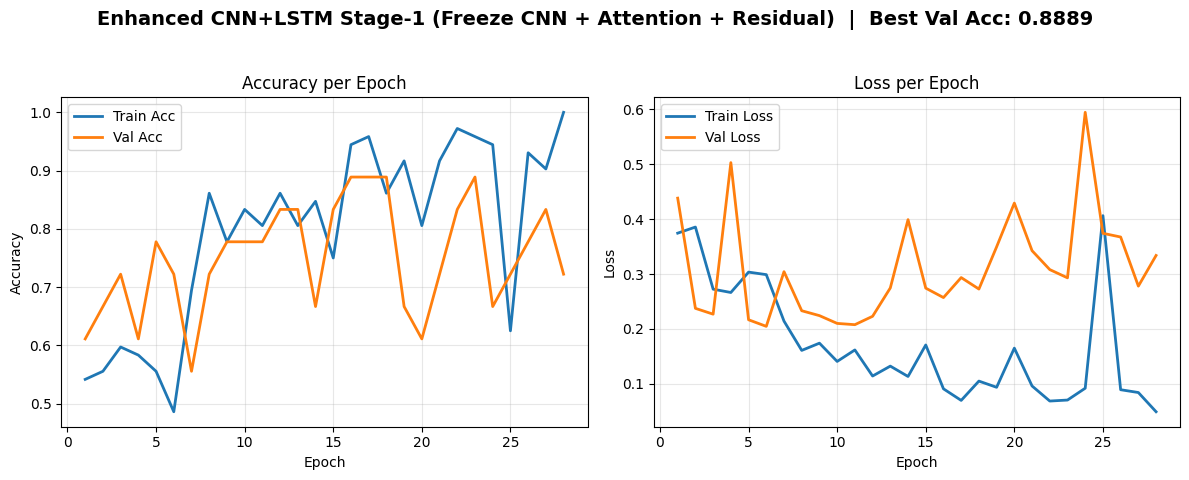

Enhanced Model Prediction: person_exiting
  normal_parking  : 0.2628
  person_exiting  : 0.7372
Frames used: 16/16 • The Dataset/1/event_v004_p048_295


In [20]:

best_model, history, results = main()

if best_model is not None:
    # ganti path ini dengan folder sequence yang mau kamu tes
    seq_dir = "The Dataset/1/event_v004_p048_295"   # <-- contoh
    try:
        result = run_prediction_test(seq_dir=seq_dir)
    except Exception as e:
        logger.error(f"Prediction test failed: {e}")
else:
    logger.error("\nStage 1 CNN+LSTM implementation failed")


In [21]:
seq_dir = "The Dataset/1/vehicle_1_1754727365"   # <-- contoh
try:
    result = run_prediction_test(seq_dir=seq_dir)
except Exception as e:
    logger.error(f"Prediction test failed: {e}")

Enhanced Model Prediction: person_exiting
  normal_parking  : 0.3176
  person_exiting  : 0.6824
Frames used: 16/16 • The Dataset/1/vehicle_1_1754727365


In [29]:
seq_dir = "untuk_testing_saja/test_dataset_0"   # <-- test
try:
    result = run_prediction_test(seq_dir=seq_dir)
except Exception as e:
    logger.error(f"Prediction test failed: {e}")

Enhanced Model Prediction: person_exiting
  normal_parking  : 0.4725
  person_exiting  : 0.5275
Frames used: 16/16 • untuk_testing_saja/test_dataset_0


## Tes ulang model

In [2]:
import glob

# Test all sequences in the dataset

# Get all sequence directories from both classes
seq_dirs = []
for class_label in [0, 1]:
  class_path = f"The Dataset/{class_label}/*"
  seq_dirs.extend(glob.glob(class_path))

print(f"Found {len(seq_dirs)} sequence directories to test")

# Test a sample of sequences (you can change this to test all)
sample_size = max(10, len(seq_dirs))  # Test first 10 or all if less than 10
test_dirs = seq_dirs[:sample_size]

results = []
for seq_dir in test_dirs:
  try:
      result = run_prediction_test(seq_dir=seq_dir)
  except Exception as e:
      logger.error(f"Prediction test failed: {e}")

Found 0 sequence directories to test
